<a href="https://colab.research.google.com/github/mainguyen1901/Practice_CMPS260/blob/main/SOA_Universities_Scraping_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import requests
import re
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

!pip install unidecode # Import Unidecode to remove accent
from unidecode import unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 5.3 MB/s eta 0:00:00


In [ ]:
# SOA Universities List

# Use an HTTP request to download the page data
page = requests.get('https://www.soa.org/institutions/')
pagesoup = BeautifulSoup(page.content, 'html.parser')

In [ ]:
# Find the first sortable table tag
table = pagesoup.find('table', class_="table table-hover table-bordered table--sortable")
rows = table.find_all('tr') 

In [ ]:
# Get the column names from the first row
column_names = []
for header in rows[0].find_all('th'):
  title = ''.join(list(header.stripped_strings))
  column_names.append(title)

# Now build up a list of lists for the data
# The data is a list of rows, each of which is a list of cells
row_list = [] # the list of rows
for row in rows[1:]: # start at row 1
  current_row = [] # start a new row list
  for cell in row.find_all('td'):
    text = ''.join(list(cell.stripped_strings))
    current_row.append(text) # add to the current row
  row_list.append(current_row) # add the current row to the row list

print(row_list[0:1])

[['Abilene Christian University', 'Bachelors', 'UCAP-IC', 'Texas', 'United States']]


In [ ]:
# Turn the row list into a dataframe and use the column names
df = pd.DataFrame(row_list, columns=column_names)
df.head()

,Name,Level of Actuarial Courses Offered,SOA Recognition Tier,State/Province,Country/Territory
0,Abilene Christian University,Bachelors,UCAP-IC,Texas,United States
1,Acadia University,Bachelors,UCAP-IC,Nova Scotia,Canada
2,Anahuac University,Bachelors,UCAP-IC,Huixquilucan,Mexico
3,Anderson University,Bachelors,UCAP-IC,Indiana,United States
4,Appalachian State University,Bachelors,UCAP-AC,North Carolina,United States


In [ ]:
df2 = df.drop(['Level of Actuarial Courses Offered','SOA Recognition Tier','State/Province','Country/Territory'], axis=1)
df2.rename(columns={'Name': 'University'}, inplace=True)
df2.head()

,University
0,Abilene Christian University
1,Acadia University
2,Anahuac University
3,Anderson University
4,Appalachian State University


In [ ]:
# SOA Universities - Contacts List

# Create a new DataFrame to store the contact information
contact_dict = {"University": [], "Contact Name": [], "Email": [], "Phone Number": []}

for index, row in df2.iterrows():
    # Get the name of the university from the "University" column
    university_name = row["University"]
    university_name = unidecode(university_name)
    # Construct the URL for the university
    url = f"https://www.soa.org/institutions/{university_name.lower().replace(' ', '-').replace(',', '')}/"
    url = url.replace('\'', '').replace('- ', '')

    # Send a request to the website
    page = requests.get(url)
    if page.status_code != 200:
      # Try modifying the URL by replacing "university" with "college"
        url = url.replace('university', 'college')
        page = requests.get(url)
        if page.status_code != 200:
            # If the modified URL still doesn't work, add additional URL variations for universities with special web links
            special_urls = {
                "Carleton University": "https://www.soa.org/institutions/carleton-university2/",
                "College of William & Mary": "https://www.soa.org/institutions/college-of-william--mary/",
                "Maryville University of St. Louis": "https://www.soa.org/institutions/maryville-st-louis/",
                "Minnesota State University - Mankato": "https://www.soa.org/institutions/minnesota-state-university-mankato/",
                "Shanghai Lixin University of Accounting and Finance": "https://www.soa.org/institutions/shanghai-lixin-university/",
                # "Southern Illinois University – Carbondale": "https://www.soa.org/institutions/southern-illinois-university-carbondale/", # Link error
                "St. Marys University": "https://www.soa.org/institutions/st-marys-university/",
                "Texas A&M University": "https://www.soa.org/institutions/texas-a-and-m-university/",
                "Dordt University": "https://www.soa.org/institutions/dordt-college/",
                # "Universite Laval": "soa.org/institutions/universite--laval/", # Link error
                "Universiti Sains Islam Malaysia (USIM)": "https://www.soa.org/institutions/Universiti-Sains-Islam-Malaysia/",
                "University at Buffalo, SUNY": "https://www.soa.org/institutions/university-at-buffalo/",
                "University of California Santa Barbara (UCSB)": "https://www.soa.org/institutions/university-of-california-santa-barbara/",
                "University of Lisbon/ISEG (Lisboa School of Economics and Management)": "https://www.soa.org/institutions/university-of-lisbon-iseg-lisboa-school-of-economics-and-management/",
                "University of Massachusetts - Boston": "https://www.soa.org/institutions/university-of-massachusetts-boston/",
                # "University of the Philippines – Diliman": "https://www.soa.org/institutions/university-of-the-philippines-diliman/", # Link error
                "University of Washington | Bothell": "https://www.soa.org/institutions/university-of-washington-bothell/"
            }
        if university_name in special_urls:
            url = special_urls[university_name]
        else:
            print(f"No contact information found for {university_name}")
            continue
        page = requests.get(url)
    # Parse the HTML content of the website using Beautiful Soup
    soup = BeautifulSoup(page.content, "html.parser")
     # Extract the contact information for the university
    contact_info = soup.findAll("div", {"class": "college-institution__contact"})
    if len(contact_info):
        div = contact_info[0]
        # Extract the contact name, email, and phone number from the contact information
        contact_name_tag = div.find('a')
        if contact_name_tag is not None and len(contact_name_tag.contents) > 0:
            contact_name = contact_name_tag.contents[0]
        else:
            contact_name = None
        email_tag = div.find('a', href=re.compile(r"[^mailto].+"))
        if email_tag is not None:
            email = email_tag['href']
            email = email.replace('mailto:', '')
        else:
            email = None
        phone_number_pattern = r'\+1[-\.]\d{3}[-\.]\d{3}[-\.]\d{4}'  # Pattern to match the phone number
        phone_number_match = re.search(phone_number_pattern, div.text)  # Search for the pattern in the text
        if phone_number_match:
            phone_number = phone_number_match.group()  # Extract the phone number from the match object
        else:
            phone_number = None

        # Add the contact information to the DataFrame
        contact_dict["University"].append(university_name)
        contact_dict["Contact Name"].append(contact_name)
        contact_dict["Email"].append(email)
        contact_dict["Phone Number"].append(phone_number)

    else:
        print(f"No contact information found for {university_name}")

contact_df = pd.DataFrame(contact_dict)
contact_df # Print the DataFrame


No contact information found for Bayes Business School - City, University of London
No contact information found for Shanghai University of International Business & Economics
No contact information found for Southern Illinois University - Carbondale
No contact information found for Spring Arbor University
No contact information found for Universite Laval
No contact information found for University of the Philippines - Diliman


,University,Contact Name,Email,Phone Number
0,Abilene Christian University,Mark Riggs,mark.riggs@acu.edu,+1.325.674.2551
1,Acadia University,Iain Beaton,iain.beaton@acadiau.ca,+1-506-470-1450
2,Anahuac University,Víctor Hugo Ibarra Mercado,vibarra@anahuac.mx,None
3,Anderson University,Courtney Taylor,cktaylor@anderson.edu,+1.765.641.4410
4,Appalachian State University,Kevin Shirley,shirleykl1@appstate.edu,+1-828-262-6975
...,...,...,...,...
311,Xi'an Jiaotong-Liverpool University,JIajun Liu,jiajun.liu@xjtlu.edu.cn,None
312,York University,Edward Furman,efurman@mathstat.yorku.ca,+1.416.736.2100
313,Youngstown State University,Thomas Wakefield,tpwakefield@ysu.edu,+1.330.941.1395
314,Yunnan University of Finance and Economics,Yunxian Li,liyunxian71@hotmail.com,None


In [ ]:
contact_df.to_csv('/content/drive/MyDrive/Actuarial Consultant Intern/3. Web Scraping/University_List.csv', index=False) # Export as CSV file (/path/file_name.csv)

In [ ]:
# SOA Universities - Data Analysis (Now let's do something fun!)

df = pd.DataFrame(row_list, columns=column_names)
df.rename(columns={'Name': 'University', 'Level of Actuarial Courses Offered': 'Degree', 'SOA Recognition Tier': 'Tier', 'State/Province': 'State', 'Country/Territory': 'Country'}, inplace=True)
df.head()

,University,Degree,Tier,State,Country
0,Abilene Christian University,Bachelors,UCAP-IC,Texas,United States
1,Acadia University,Bachelors,UCAP-IC,Nova Scotia,Canada
2,Anahuac University,Bachelors,UCAP-IC,Huixquilucan,Mexico
3,Anderson University,Bachelors,UCAP-IC,Indiana,United States
4,Appalachian State University,Bachelors,UCAP-AC,North Carolina,United States


In [ ]:
# Which country has the highest number of SOA Affiliated Universities?
uni_counts = df.groupby(['Country']).size().reset_index(name='Uni_Counts')
uni_counts.head()

,Country,Uni_Counts
0,Argentina,1
1,Australia,4
2,Cameroon,1
3,Canada,21
4,China,23


In [ ]:
# Histogram of SOA Affiliated Universities by Country
uni_his = alt.Chart(uni_counts).mark_bar(color = 'teal').encode(
    alt.X('Country:N', title='Countries'),
    alt.Y('Uni_Counts:Q', title='Number Universities', scale=alt.Scale(type='log')), # The data is pretty skewed to the righ, we should take the natural log to scale it
    tooltip=[alt.Tooltip('Country:N', title='Country'), alt.Tooltip('Uni_Counts:Q', title='Number of Universities')]
).properties(
    title='Total Number of SOA Affiliated Universities by Country'
)

mean_line = alt.Chart(uni_counts).mark_rule(color='red').encode(
    y='mean(Uni_Counts):Q',
    size=alt.value(2)
)

uni_his + mean_line # Answers: It's the United States!

alt.LayerChart(...)

In [ ]:
# Does the country/state with highest number of SOA Affiliated Universities also have the highest number of UCAP-IC	Tier?

tier_counts = df.groupby(['Country','Tier']).size().reset_index(name='Tier_Counts')
tier_counts.head()

,Country,Tier,Tier_Counts
0,Argentina,UCAP-AC,1
1,Australia,CAE,2
2,Australia,CAE/UEC,2
3,Cameroon,UCAP-AC,1
4,Canada,CAE,8


In [ ]:
filtered_df = tier_counts[tier_counts['Tier_Counts'] > 2]
filtered_df

,Country,Tier,Tier_Counts
4,Canada,CAE,8
5,Canada,UCAP-AC,7
6,Canada,UCAP-IC,6
8,China,UCAP-AC,13
9,China,UCAP-IC,9
21,Malaysia,UCAP-AC,7
35,United States,CAE,11
36,United States,CAE/UEC,9
37,United States,UCAP-AC,56
38,United States,UCAP-IC,154


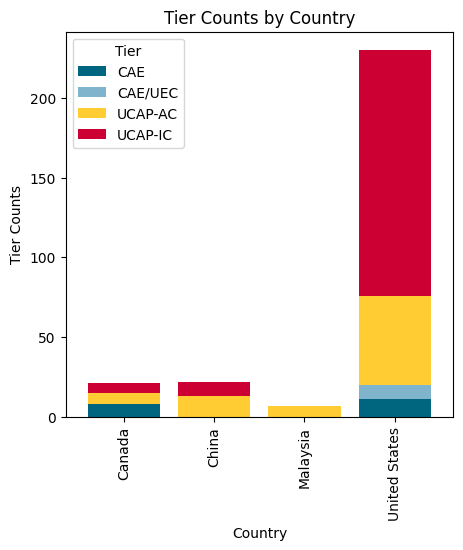

In [ ]:
# Stacked bar graph of Tier Counts by Country
fig, ax = plt.subplots(figsize=(5, 5))

# Group the dataframe by "Country" and "Tier" and sum the "Tier_Counts" column
grouped = filtered_df.groupby(['Country', 'Tier'])['Tier_Counts'].sum()

# Unstack the grouped dataframe to create a stacked bar graph
unstacked = grouped.unstack()
colors = [(0.0, 0.4, 0.5), (0.5, 0.7, 0.8), (1.0, 0.8, 0.2), (0.8, 0.0, 0.2)]
unstacked.plot(kind='bar', stacked=True, ax=ax, color=colors, width=0.8)
ax.set_xlabel('Country', fontsize=10)
ax.set_ylabel('Tier Counts', fontsize=10)
ax.set_title('Tier Counts by Country', fontsize=12)

plt.show() # Expectedly, it's also the United States which has the highest number of SOA Affiliated Universities and the highest number of UCAP-IC	Tier!

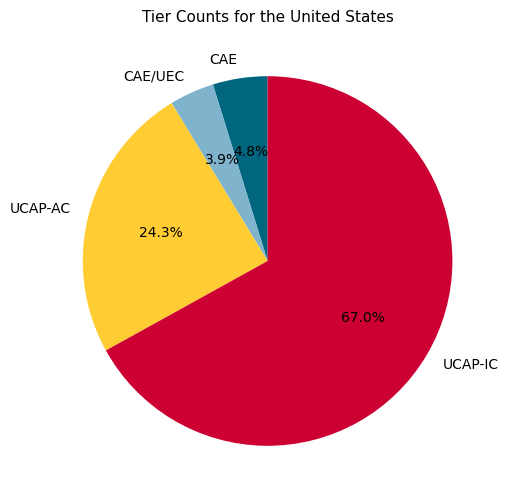

In [ ]:
# Pie chart of Tier distribution in the United States
us_data = filtered_df[filtered_df['Country'] == 'United States']

grouped = us_data.groupby(['Tier'])['Tier_Counts'].sum()
fig, ax = plt.subplots(figsize=(6, 6))
colors = [(0.0, 0.4, 0.5), (0.5, 0.7, 0.8), (1.0, 0.8, 0.2), (0.8, 0.0, 0.2)] # list of colors
ax.pie(grouped, labels=grouped.index, autopct='%1.1f%%', startangle=90, colors=colors)

# Add a title to the pie chart
ax.set_title('Tier Counts for the United States', fontsize=11)

# Show the plot
plt.show()
